In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1. Load Data

In [13]:
data = pd.read_csv('/Users/ChunyanHao/desktop/github/ds_take_home/data/referral.csv')

In [5]:
data.head(3)

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      97341 non-null  int64 
 1   date         97341 non-null  object
 2   country      97341 non-null  object
 3   money_spent  97341 non-null  int64 
 4   is_referral  97341 non-null  int64 
 5   device_id    97341 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.5+ MB


In [15]:
data['date'] = pd.to_datetime(data['date'])

In [16]:
for column in data.columns:
    uniques = data[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              18809	 [ 2  3  6  7 10]
date                    56	 ['2015-10-03T00:00:00.000000000' '2015-10-04T00:00:00.000000000'
 '2015-10-05T00:00:00.000000000' '2015-10-06T00:00:00.000000000'
 '2015-10-07T00:00:00.000000000']
country                  9	 ['FR' 'CA' 'UK' 'MX' 'DE']
money_spent            165	 [65 54 35 73 36]
is_referral              2	 [0 1]
device_id            17887	 ['EVDCJTZMVMJDG' 'WUBZFTVKXGQQX' 'CBAPCJRTFNUJG' 'PRGXJZAJKMXRH'
 'CVZCQLPXZCFUV']


## 2. Question 1

The program has been running for almost a month and the Growth Product Manager wants to know if it's been successful. She is very excited cause, since the referral program started, the company saw a spike in number of users and wants you to be able to give her some data she can show to her boss.

Can you estimate the impact the program had on the site?

For the purpose of showing the referral program effect, we can display in the following aspects:

1) number of users(referral or not) with transaction each day

2) total daily transaction amount, transaction by referral users

### 2.1 users increase

In [69]:
daily_user = data.groupby(['date', 'is_referral'])['user_id'].unique().reset_index()
daily_user['user_count'] = daily_user['user_id'].apply(lambda x: len(x))

user_first_day = data.groupby(['user_id', 'is_referral'])['date'].agg('min').reset_index()
#remove the first two days when all existed users are taken as new users, which is out of business sense
user_first_day = user_first_day[user_first_day.date > '2015-10-04']

[Text(0.5, 1.0, 'New User Referred or not')]

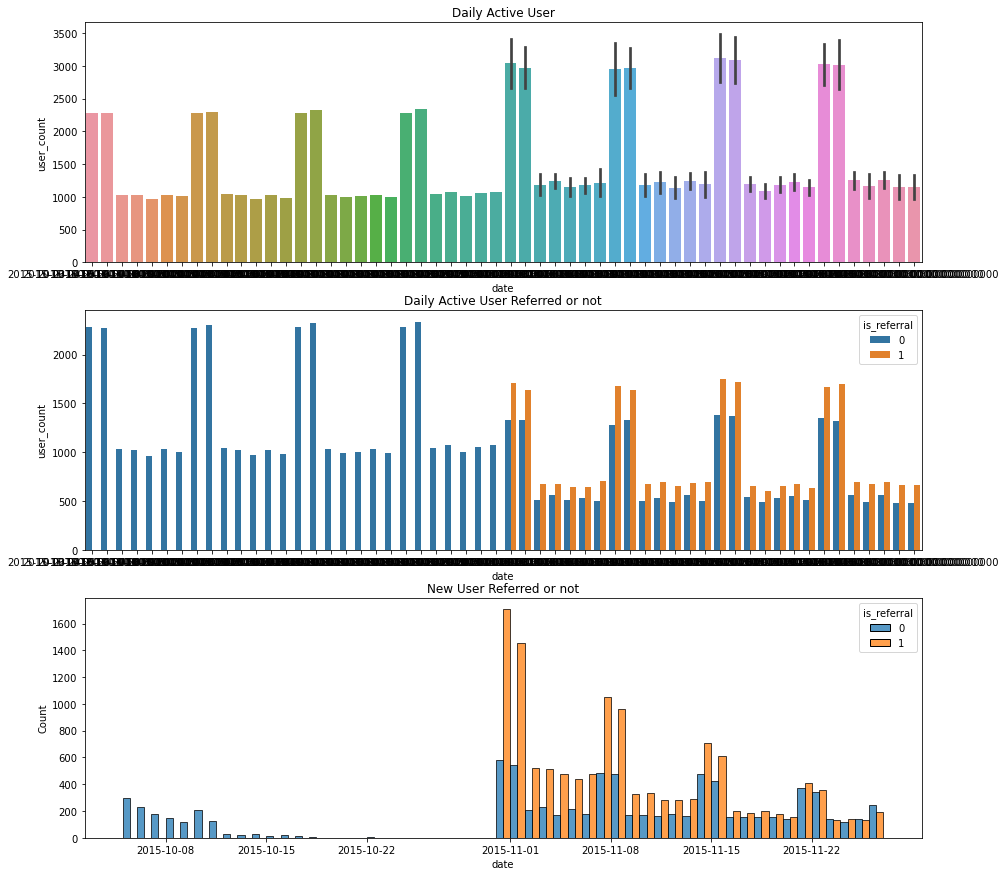

In [70]:
fig, ax = plt.subplots(3, 1, figsize = (15, 12))

sns.barplot(data = daily_user, x = 'date', y = 'user_count', 
            estimator = sum, ax = ax[0]).set(title='Daily Active User')

sns.barplot(data = daily_user, x = 'date', y = 'user_count', 
            hue = 'is_referral',  dodge = True, ax = ax[1]).set(title='Daily Active User Referred or not')

sns.histplot(data = user_first_day, x = 'date', 
             hue = 'is_referral',  multiple='dodge', ax = ax[2]).set(title='New User Referred or not')

Plots above display 3 important patterns:

1) The number of users use the website is larger in weekends than in weekdays.

2) Since the referral program started, many referred users started to spend money in the website. However, the number of non-referred users decreased significantly. But the total daily active users doesn't increase a lot.

3) As time goes by, the effect of referral program decreased gradually, because the number of new users is decreasing.

### 2.2 daily transaction amount

<AxesSubplot:xlabel='date', ylabel='money_spent'>

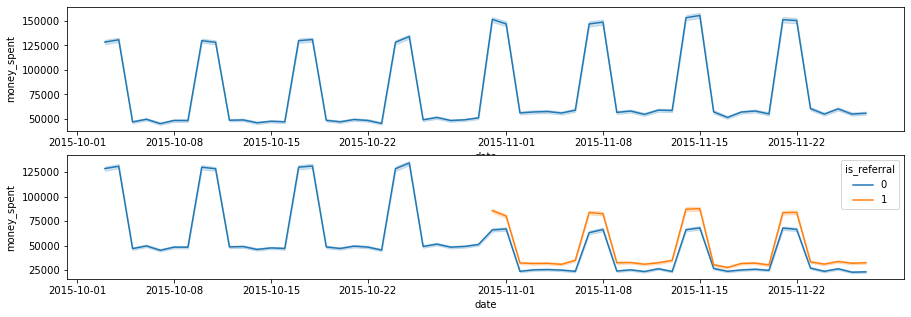

In [51]:
fig, ax = plt.subplots(2, 1, figsize = (15, 8))
sns.lineplot(data = data, x = 'date', y = 'money_spent', estimator = sum, ax = ax[0])
sns.lineplot(data = data, x = 'date', y = 'money_spent', hue = 'is_referral', estimator = sum, ax = ax[1])

The two line plots above show 3 interesting phenomenons in the daily transaction:

1) There daily transaction is significantly larger in weekends than in weekdays.

2) Since the referral program started, the total transaction amount increased a little compared with previous.

3) Since the referral program started, amount spent by non-referral users decreased significantly, while amount spent by referred users is a little bit higher than the non-referral users. There is one potential that the old users created new accounts as referred users in order to get extra $10 in credit. As the result, their previous consumption power is diluted into their now accounts.

## 3. Question 2

Based on the data, what would you suggest to do as a next step?

As analyzed above, the overall effect of this referral program doesn't seem so good. One alternative approach is to analyze the data in different segments. Because we have the information of users' country, we can then implement further analysis in the following way:

<AxesSubplot:xlabel='date', ylabel='daily_sum'>

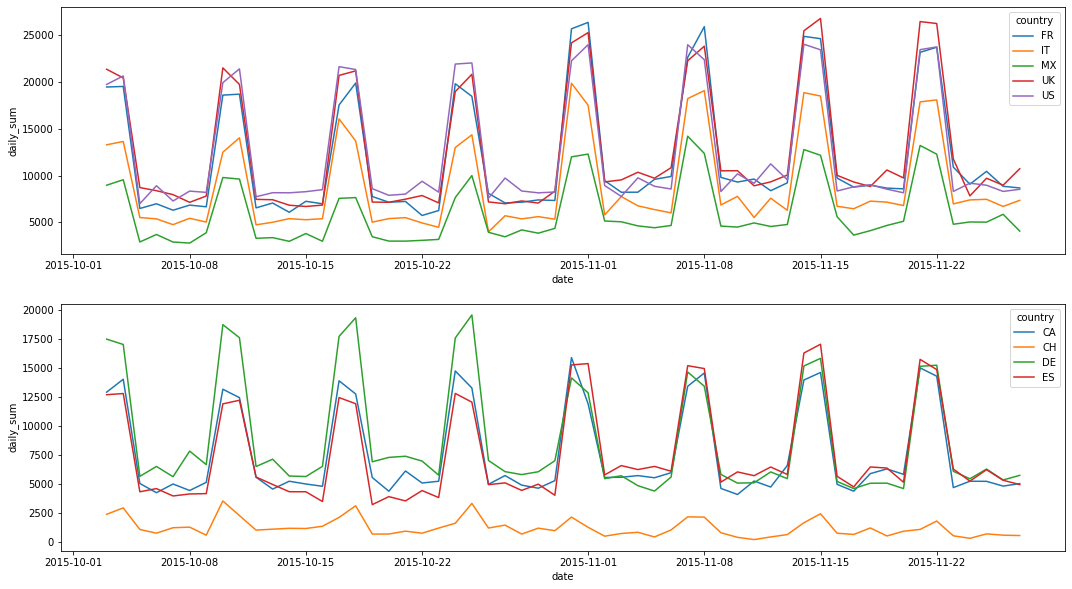

In [99]:
country_day = data.groupby(['country', 'date'])['money_spent'].sum().reset_index(name = 'daily_sum')
country_day_1 = country_day[country_day.country.isin (['UK', 'FR', 'US', 'IT', 'MX'])]
country_day_2 = country_day[~country_day.country.isin (['UK', 'FR', 'US', 'IT', 'MX'])]
fig, ax = plt.subplots(2, 1,figsize = (18, 10))
sns.lineplot(data = country_day_1, x = 'date', y = 'daily_sum', hue = 'country', ax = ax[0])
sns.lineplot(data = country_day_2, x = 'date', y = 'daily_sum', hue = 'country', ax = ax[1])

From the line plots above it's clear that the referral program is more effective in countries including 'US', 'UK', 'FR' and 'IT'. While countries like 'CH', 'DE' and 'CA' are not so sensitive to it.

In order to verify our argument based on plots, we can implement A/B test in each country:

In [124]:
from scipy.stats import ttest_ind

In [229]:
data.country.unique()

array(['FR', 'CA', 'UK', 'MX', 'DE', 'US', 'IT', 'ES', 'CH'], dtype=object)

In [353]:
def A_B_test(df):
    print('A_B_test for "daily transaction amount" and "daily unique active user": \n')
    print('{0:10s} {1:7s} {2:>13s} {3:>13s} {4:>9s} {5:>14s} {6:>10s} {7:>11s} {8:>8s}'.format(
        'Country', 'before_amount', 'after_amount', 'amount_diff', 'P-value', 'before_unique', 'after_unique', 'unique_diff', 'P-value'))
    print('-' * 110)
    for country in df.country.unique():
        before_referral = df[(df.country == country) & (df.date < '2015-10-31')]
        after_referral = df[(df.country == country) & (df.date >= '2015-10-31')]

        # AB test for daily total transaction amount
        before_amount = before_referral.groupby(['date'])['money_spent'].sum()
        before_amount_mean = before_amount.mean()

        after_amount = after_referral.groupby(['date'])['money_spent'].sum()
        after_amount_mean = after_amount.mean()

        daily_amount_result = ttest_ind(before_amount, after_amount, axis=0, equal_var=False)
        daily_amount_pvalue = daily_amount_result.pvalue

        # AB test for daily unique active users

        before_unique = before_referral.groupby(['date'])['user_id'].nunique()
        before_unique_mean = before_unique.mean()

        after_unique = after_referral.groupby(['date'])['user_id'].nunique()
        after_unique_mean = after_unique.mean()

        daily_unique_result = ttest_ind(before_unique, after_unique, axis=0, equal_var=False)
        daily_unique_pvalue = daily_unique_result.pvalue
        
        print('{0:10s} {1:8.2f} {2:14.2f} {3:14.2f} {4:9.2f} {5:10.2f} {6:13.2f} {7:13.2f} {8:10.2f}'.format(
            country, before_amount_mean, after_amount_mean, after_amount_mean - before_amount_mean, daily_amount_pvalue, 
                    before_unique_mean, after_unique_mean, after_unique_mean - before_unique_mean, daily_unique_pvalue))

In [354]:
df = data
A_B_test(df)

A_B_test for "daily transaction amount" and "daily unique active user": 

Country    before_amount  after_amount   amount_diff   P-value  before_unique after_unique unique_diff  P-value
--------------------------------------------------------------------------------------------------------------
FR         10385.25       13635.00        3249.75      0.06     236.50        302.54         66.04       0.08
CA          7468.43        7880.43         412.00      0.70     173.29        159.18        -14.11       0.54
UK         11213.54       14196.43        2982.89      0.10     255.57        286.32         30.75       0.41
MX          4975.46        7033.21        2057.75      0.02     124.39        163.11         38.71       0.05
DE          9856.75        8013.96       -1842.79      0.16     224.96        163.25        -61.71       0.03
US         11921.04       13077.46        1156.43      0.50     273.18        261.11        -12.07       0.74
IT          7651.57       10193.43        2

From the Ab test results above, we notice that:

1) This referral program improves daily transaction amount in 'MX' and 'IT' significantly; but decreases daily transaction amount in 'CH'.

2) It improves daily active user count in 'MX'; but decreases daily active user count in 'DE' and 'CH'.

3) To summarize, this referral program is most useful in 'MX', but meanwhile bring negative effect to both 'CH' and 'DE'.

## Question 3

The referral program wasn't really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the referral program and measure its impact?

What kinds of risks this approach presents? 

1) Referral or not is not the only one condition difference between control and experiment group. For example, in November, there is a shopping holiday which might stimulate the sales amount significantly.

2) If the referral program has negative effect to customer's consumption preference like in 'CH' and 'DE', it might decrease website's sales performance.

Better way to test the referral program and measure its impact

1) Do more research on consumer's consumption preference in each country, estimate the potential risk in advance.

2) Randomly split a small percentage of users into control and experimental group, avoid information leakage among control and experimental group

2) Select normal season, avoid holidays and other peak shop